Universidade Estadual Paulista - UNESP

Programa de Pós-Graduação em Ciência da Computação

**Processamento de Imagens Digitais**

Professor Leandro Alves Neves

Alunos: 
* Giovanna Carreira Marinho;
* Guilherme Francisco de Andrade Campos;
* Julia Rodrigues Gubolin;
* Thales Ricardo de Souza Lopes.

**Aula 9 - Segmentação**

**Exercício 2**: Implemente e execute a técnica de Otsu sobre a imagem. Inicialmente, o algoritmo deve ser capaz de separar duas classes (fundo e objeto). Em seguida, modifique o código para objer três classes como resultado. Apresente os valores dos limiares e as imagens que definem cada uma das duas classes. As máscaras devem ser aplicadas para segmentar regiões coloridas que definem cada classe.

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from skimage import exposure
from skimage import data
from skimage.filters import threshold_multiotsu
from skimage.io import imread, imshow
from skimage.color import rgb2gray

# Leitura da imagem e conversão para tons de cinza

Leitura da imagem do exercício por meio do método *imread* (do pacote *skimage*). O método *imshow*, do mesmo pacote, é utilizada em seguida para exibir a imagem.

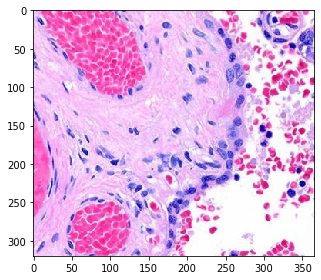

In [ ]:
rgb_image = imread('/content/Img_seg.jpg')
imshow(rgb_image)

Analisando o formato da imagem: 320 linhas, 366 colunas e 3 canais (RGB).

In [ ]:
rgb_image.shape

(320, 366, 3)

Convertendo a imagem para tons de cinza pelo método *rgb2gray* (do pacote *skimage*). Como o resultado de saída está dentro do intervalo [0, 1], é feito um mapeamento para o intervalo [0, 255]. O resultado da conversão é apresentado em seguida.

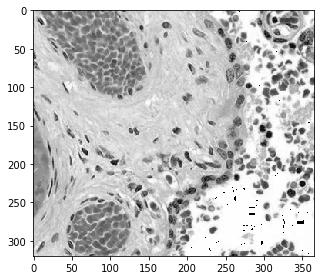

In [ ]:
gray_scale = rgb2gray(rgb_image)
gray_image = (gray_scale*256).astype('uint8')
imshow(gray_image, cmap='gray')

O método *hist* (do pacote *matplotlib.pyplot*) exibe o histograma de uma imagem, ou seja, a distribuição das frequências das intensidades de uma imagem.

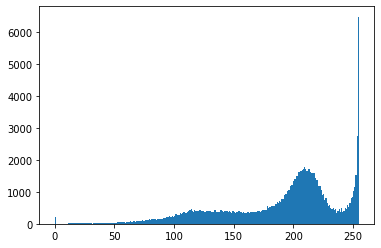

In [ ]:
plt.hist(gray_image.ravel(), bins=255)
plt.show()

# Multi-Otsu para 2 classes (uso de bliblioteca)

O pacote *skimage.filters* disponibiliza um método para a técnica de Otsu. O mesmo é utilizado para que os resultados seram comparados com aqueles obtidos pela implementação própria. Ele recebe como entrada a imagem e o número de classes. O resultado é uma lista com os limiares de cortes, que separam essas classes. Em seguida, deve ser utilizado o método *digitize* (do pacote *numpy*) para que a segmentação da imagem seja feita de acordo com esses pontos de corte.

In [ ]:
thresholds = threshold_multiotsu(gray_image, classes=2)
regions = np.digitize(gray_image, bins=thresholds)

Nesse exemplo, o ponto de corte retornado pelo método foi 169. Ou seja, pixels cuja intensidade seja menor que do limiar irão ter uma cor atribuída e aqueles com intensidade maior receberão outra.

In [ ]:
thresholds

array([169])

O bloco de código a seguir exibe o histograma com a linha vertical vermelha indicando o ponto de corte.

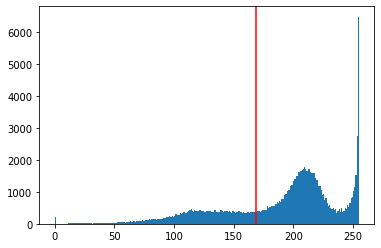

In [ ]:
plt.hist(gray_image.ravel(), bins=255)
for thresh in thresholds:
    plt.axvline(thresh, color='r')
plt.show()

A figura a seguir apresenta o resultado da segmentação (obtida pelo uso de implementações da biblioteca).

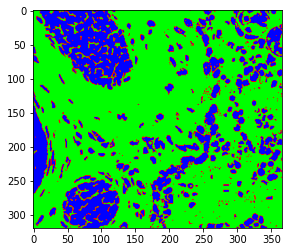

In [ ]:
plt.imshow(regions, cmap='brg')

# Multi-Otsu para 3 classes (uso de bliblioteca)

Realizando o mesmo procedimento para 3 classes.

In [ ]:
thresholds = threshold_multiotsu(gray_image, classes=3)
regions = np.digitize(gray_image, bins=thresholds)

Observa-se que os limiares que separam as 3 classes são, para esse exemplo: 156 e 218.

In [ ]:
thresholds

array([156, 218])

O bloco a seguir permite analisar graficamente esses valores no histograma.

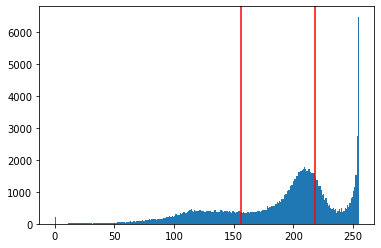

In [ ]:
plt.hist(gray_image.ravel(), bins=255)
for thresh in thresholds:
    plt.axvline(thresh, color='r')
plt.show()

Verificando, pelo método *unique* do pacote *numpy*, quantos elementos existem no resultado, observa-se que existem 3 classes (com várias ocorrências).

In [ ]:
np.unique(regions)

array([0, 1, 2])

O código abaixo exibe o resultado da segmentação pela técnica de Otsu para 3 classes.

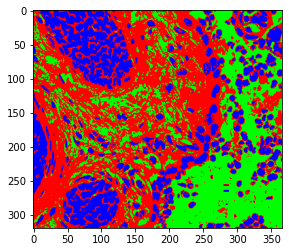

In [ ]:
plt.imshow(regions, cmap='brg')

# Implementação Multi-Otsu

As funções a seguir implementam o método de Otsu para duas e três classes, além do método de atribuição de intensidade aos pixels da imagem de acordo com os limiares de corte.

In [ ]:
def our_threshold_multiotsu_2(image):
  threshold_range = range(np.max(image) + 1) #será testados todos os limiares de 0 a maior intensidade da imagem
  criterias = []

  for th in threshold_range: #para cada intensidade
    thresholded_im = np.zeros(image.shape) #cria uma imagem vazia
    thresholded_im[image >= th] = 1 #e segmenta a imagem de acordo com o limiar

    nb_pixels = image.size #quantidade de pixels
    nb_pixels1 = np.count_nonzero(thresholded_im) #quantidade de pixels maiores ou iguais ao limiar
    weight1 = nb_pixels1 / nb_pixels #probabilidade do pixel cair em uma classe
    weight0 = 1 - weight1 #probabilidade do pixel cair na outra classe

    if weight1 == 0 or weight0 == 0: #caso uma das classes estejam vazias
      criterias.append(10000)

    val_pixels1 = image[thresholded_im == 1] #encontrando os pixels que pertence a cada classe
    val_pixels0 = image[thresholded_im == 0]

    var0 = np.var(val_pixels0) if len(val_pixels0) > 0 else 0 #calculando a variancia das classes
    var1 = np.var(val_pixels1) if len(val_pixels1) > 0 else 0

    criterias.append(weight0 * var0 + weight1 * var1) #variancia entre classes: soma ponderada entre peso e variancia

  best_threshold = threshold_range[np.argmin(criterias)] #o melhor limiar é aquele que minimiza a variancia entre-classes

  return best_threshold, criterias

In [ ]:
def our_threshold_multiotsu_3(image): #abordagem um pouco diferente da funcao anterior
  max_value = np.max(image)
  hist, bins = np.histogram(image, bins=max_value) #calcula o histograma da imagem
  p = hist / image.size #histograma normalizado

  thresholds = []
  variances = []

  th_1 = 0
  
  while th_1 <= (max_value - 1): #selecionando o primeiro limiar
    supposed_th = []
    supposed_variances = []

    th_2 = th_1 + 1

    while th_2 <= max_value: #selecionando o segundo limiar (sempre a frente do primeiro)
      p_1 = np.sum(p[:th_1]) #calculando a probabilidade do pixel cair em cada classe
      p_2 = np.sum(p[th_1:th_2])
      p_3 = np.sum(p[th_2:])
      
      if p_1 == 0 or p_2 == 0 or p_3 == 0 :
        th_2 += 1
        continue

      m_1 = (1/p_1) * np.sum([i*p_i for i, p_i in zip(p[:th_1], np.arange(0, th_1))]) #calculando a variancia de cada classe
      m_2 = (1/p_2) * np.sum([i*p_i for i, p_i in zip(p[th_1:th_2], np.arange(th_1, th_2))]) 
      m_3 = (1/p_3) * np.sum([i*p_i for i, p_i in zip(p[th_2:], np.arange(th_2, max_value))]) 

      m_g = p_1*m_1 + p_2*m_2 + p_3*m_3 #intensidade global média

      class_variance = p_1*(m_1 - m_g)**2 + p_2*(m_2 - m_g)**2 + p_3*(m_3 - m_g)**2 #calculando a variancia entre as classes
      
      supposed_variances.append(class_variance)
      supposed_th.append((th_1, th_2))

      th_2 += 1

    if len(supposed_variances) > 0: #depois de testar supostos par de limires para cada um do primeiro limiar, obtem o melhor de cada teste
      variances.append(max(supposed_variances)) #o melhor é aquele cuja variancia é maxima
      thresholds.append(supposed_th[supposed_variances.index(max(supposed_variances))])

    th_1 += 1

  return thresholds[variances.index(max(variances))], variances #como a cada teste é testado o melhor, o "limiar global" melhor pode ser obtido pelo máximo dos "melhores locais"

In [ ]:
def our_digitize(image, thresholds):
  regions = np.zeros(image.shape) #criando uma imagem vazia para armazenar o resultado
  row, column = image.shape

  for i in range(row):
    for j in range(column): #iterando sobre as linhas i e colunas j da imagem

      for k in range(len(thresholds)): #iterando sobre os pontos de cortes (resultado da segmentação) e verificando se a intensidade do pixel para atribuir a classe ao resultado
        if image[i, j] <= thresholds[k]:
          regions[i, j] = k
          break
        elif image[i, j] > thresholds[-1]:
          regions[i, j] = len(thresholds)
          break

  return regions

# Multi-Otsu para 2 classes (implementação própria)

Executando a função para a imagem em tons de cinza, para duas classes.

In [ ]:
thresholds, criterias = our_threshold_multiotsu_2(gray_image)

O limiar nesse caso foi bem semelhante ao obtido pela biblioteca (169): 171.

In [ ]:
thresholds

171

O *plot* a seguir, permite analisar visualmente a busca do melhor limiar na primeira função.

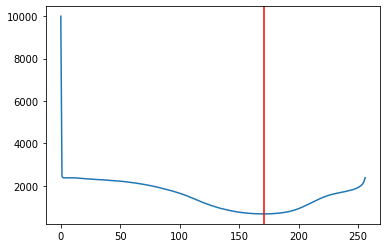

In [ ]:
plt.plot(range(np.max(gray_image) + 2), criterias)
plt.axvline(thresholds, color='r')

Executando o método próprio desenvolvido para segmentar a imagem de acordo com o limiar.

In [ ]:
regions = our_digitize(gray_image, [thresholds])

Observa-se que o resultado foi semelhate ao da biblioteca.

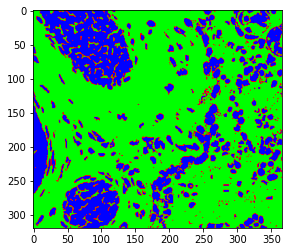

In [ ]:
plt.imshow(regions, cmap='brg')

# Multi-Otsu para 3 classes (implementação própria)

Executando a função desenvolvida para o método de Otsu para 3 classes.

In [ ]:
best_thresholds, variance = our_threshold_multiotsu_3(gray_image)

Os resultados obtidos foram bem precisos em comparação com aqueles obtidos pela biblioteca (156 e 218): 157 e 219.

In [ ]:
best_thresholds

(157, 219)

A célula a seguir exibe as variâncias e os pontos de cortes definidos pelos limiares.

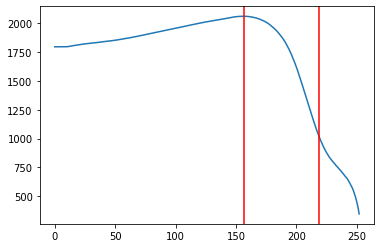

In [ ]:
plt.plot(range(len(variance)), variance)
plt.axvline(best_thresholds[0], color='r')
plt.axvline(best_thresholds[1], color='r')

Executando o método de segmentação para os limiares obtidos.

In [ ]:
regions = our_digitize(gray_image, [best_thresholds[0], best_thresholds[1]])

Exibindo o resultado visual da segmentação, semelhante à obtida pela biblioteca.

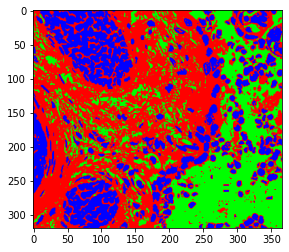

In [ ]:
plt.imshow(regions, cmap='brg')

# Referências

http://appliedmaths.sun.ac.za/TW793/slides/slides_10_4.pdf

http://appliedmaths.sun.ac.za/TW793/slides/slides_10_5.pdf

https://en.wikipedia.org/wiki/Otsu%27s_method